## Model Training

In [2]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

#### Import the CSV Data as Pandas DataFrame

In [3]:
# Load training data
df = pd.read_csv('cleaned_data.csv')

#### Show Top 5 Records

In [4]:
df.head()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,F,0-17,10,A,2,0,3,9.0,14.0,8370
1,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,F,0-17,10,A,2,0,12,9.0,14.0,1422
3,F,0-17,10,A,2,0,12,14.0,14.0,1057
4,M,55+,16,C,4+,0,8,9.0,14.0,7969


#### Preparing X and Y variables

In [5]:
X = df.drop(columns=['Purchase'],axis=1)

In [6]:
X.head()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,F,0-17,10,A,2,0,3,9.0,14.0
1,F,0-17,10,A,2,0,1,6.0,14.0
2,F,0-17,10,A,2,0,12,9.0,14.0
3,F,0-17,10,A,2,0,12,14.0,14.0
4,M,55+,16,C,4+,0,8,9.0,14.0


In [7]:
y = df['Purchase']
y

0          8370
1         15200
2          1422
3          1057
4          7969
          ...  
550063      368
550064      371
550065      137
550066      365
550067      490
Name: Purchase, Length: 550068, dtype: int64

In [8]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [9]:
X = preprocessor.fit_transform(X)

In [10]:
X.shape

(550068, 22)

In [11]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((440054, 22), (110014, 22))

#### Create an Evaluate Function to give all metrics after model Training

In [12]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

# HYPER PARAMETERS
params = {
            "Decision Tree": {
                "criterion": [
                    "squared_error",
                    "friedman_mse",
                    "absolute_error",
                    "poisson",
                ],
                # 'splitter':['best','random'],
                # 'max_features':['sqrt','log2'],
            },
            "Random Forest": {
                # 'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
                # 'max_features':['sqrt','log2',None],
                "n_estimators": [8, 16, 32, 64, 128, 256]
            },
            "Gradient Boosting": {
                # 'loss':['squared_error', 'huber', 'absolute_error', 'quantile'],
                "learning_rate": [0.1, 0.01, 0.05, 0.001],
                "subsample": [0.6, 0.7, 0.75, 0.8, 0.85, 0.9],
                # 'criterion':['squared_error', 'friedman_mse'],
                # 'max_features':['auto','sqrt','log2'],
                "n_estimators": [8, 16, 32, 64, 128, 256],
            },
            "Linear Regression": {},
            "XGBRegressor": {
                "learning_rate": [0.1, 0.01, 0.05, 0.001],
                "n_estimators": [8, 16, 32, 64, 128, 256],
            },
            "CatBoosting Regressor": {
                "depth": [6, 8, 10],
                "learning_rate": [0.01, 0.05, 0.1],
                "iterations": [30, 50, 100],
            },
            "AdaBoost Regressor": {
                "learning_rate": [0.1, 0.01, 0.5, 0.001],
                # 'loss':['linear','square','exponential'],
                "n_estimators": [8, 16, 32, 64, 128, 256],
            },
        }

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 4694.4688
- Mean Absolute Error: 3591.0636
- R2 Score: 0.1275
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 4685.0852
- Mean Absolute Error: 3586.5866
- R2 Score: 0.1264


Lasso
Model performance for Training set
- Root Mean Squared Error: 4694.4984
- Mean Absolute Error: 3591.4379
- R2 Score: 0.1274
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 4685.0906
- Mean Absolute Error: 3586.9485
- R2 Score: 0.1264


Ridge
Model performance for Training set
- Root Mean Squared Error: 4694.4838
- Mean Absolute Error: 3591.5068
- R2 Score: 0.1275
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 4685.0512
- Mean Absolute Error: 3586.9989
- R2 Score: 0.1264


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 3002.2482
- Mean Absolute Error: 2199.4825


### Results

In [14]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
7,CatBoosting Regressor,0.668674
6,XGBRegressor,0.667877
5,Random Forest Regressor,0.628485
4,Decision Tree,0.557205
3,K-Neighbors Regressor,0.498775
8,AdaBoost Regressor,0.402086
2,Ridge,0.126421
0,Linear Regression,0.126408
1,Lasso,0.126406


## CatBoost Regression

In [22]:
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score

cat_model = CatBoostRegressor()  # no fit_intercept parameter
cat_model = cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)
score = r2_score(y_test, y_pred) * 100
print("Accuracy of the model is %.2f" % score)

Learning rate set to 0.107116
0:	learn: 4746.6341200	total: 8.18ms	remaining: 8.17s
1:	learn: 4506.6378490	total: 16.5ms	remaining: 8.24s
2:	learn: 4314.0717708	total: 24.9ms	remaining: 8.28s
3:	learn: 4152.8308514	total: 33.6ms	remaining: 8.36s
4:	learn: 4023.2642474	total: 42.1ms	remaining: 8.38s
5:	learn: 3884.1815044	total: 49.5ms	remaining: 8.2s
6:	learn: 3777.6376474	total: 57.7ms	remaining: 8.19s
7:	learn: 3676.7108548	total: 65ms	remaining: 8.06s
8:	learn: 3592.8268687	total: 72.5ms	remaining: 7.99s
9:	learn: 3520.0423221	total: 80.7ms	remaining: 7.99s
10:	learn: 3465.6256342	total: 89.1ms	remaining: 8.01s
11:	learn: 3417.2247410	total: 96.8ms	remaining: 7.97s
12:	learn: 3379.9006447	total: 104ms	remaining: 7.93s
13:	learn: 3331.3125831	total: 112ms	remaining: 7.86s
14:	learn: 3299.8543479	total: 121ms	remaining: 7.92s
15:	learn: 3271.0292465	total: 129ms	remaining: 7.93s
16:	learn: 3250.0089098	total: 136ms	remaining: 7.89s
17:	learn: 3231.1583248	total: 145ms	remaining: 7.88s

## Plot y_pred and y_test

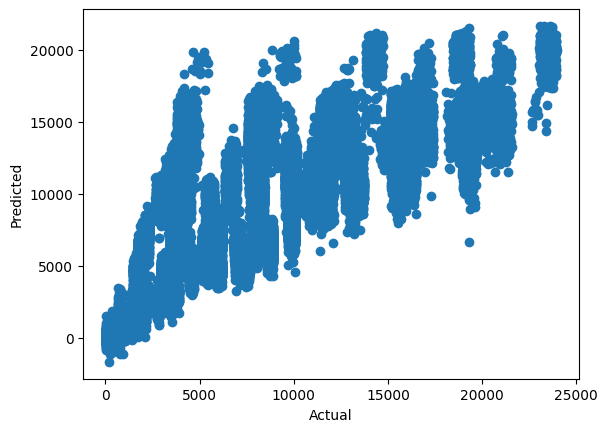

In [23]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

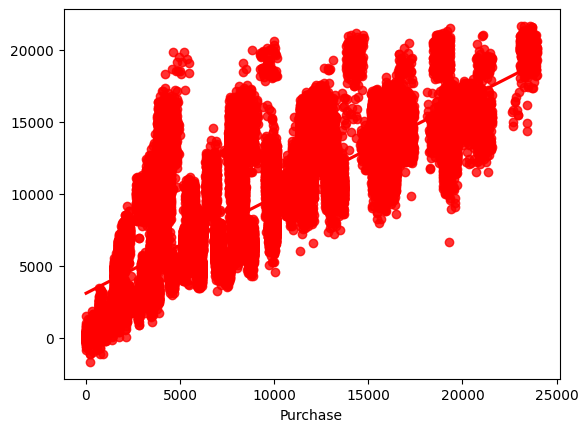

In [24]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

In [26]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
84432,19142,14302.475052,4839.524948
72724,15513,14105.566020,1407.433980
197032,7802,6883.951459,918.048541
353704,15455,13891.498311,1563.501689
91198,4492,15911.186888,-11419.186888
...,...,...,...
133324,19139,15054.035674,4084.964326
138718,7856,7171.070862,684.929138
22886,4037,6954.936131,-2917.936131
137110,7467,3936.591117,3530.408883
